# The Scattering Transform
## Linearization of the space + linear SVM


<div align="center">
 <img src="https://raw.githubusercontent.com/giulioisac/DNN-Study/master/linearization.png" >
</div>

In [5]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from scipy import ndimage as ndi
import skimage 
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

### The Data set
Working with the MNIST dataset

In [54]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [56]:
#reshape MNIST
MNIST_im=[]
for j,image in enumerate(mnist.train.images):
    MNIST_im.append(image.reshape(28,28))
np.shape(MNIST_im)
MNIST_means = np.array(MNIST_im).reshape(len(MNIST_im), -1).mean(1).astype('float32')
MNIST_im = MNIST_im - MNIST_means[:, np.newaxis, np.newaxis]

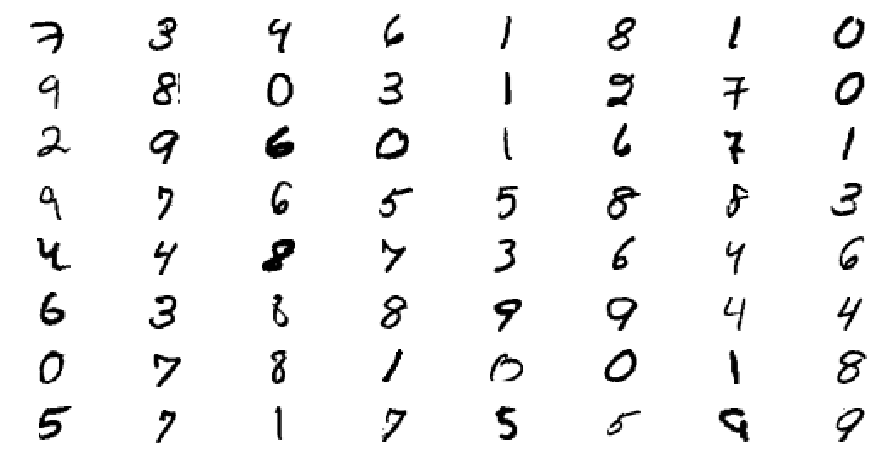

In [58]:
plt.figure(figsize=(16,8))
for j in np.arange(64):
    plt.subplot(8,8,j+1)
    plt.imshow(MNIST_im[j],interpolation='nearest',cmap=plt.get_cmap("binary"))
    plt.axis("off")

## The Wavelet Filters 
taken from [here](https://07306847857070430948.googlegroups.com/attach/19204cc059e291/gabor_vs_scattering_fortexture_classif.html?part=0.1&view=1&vt=ANaJVrH-xn9-kks1pigbDb4dLBSLLsberuGakxl8jDMIvEjmUpFfT9Z1a49xxNmn79OXYdTG_YYnJpnJmd3APa2Peqn9zALoo0I6ec9NbgyG3A23niM4rzE)

In [3]:
def create_gabor_filterbank(J=4,L=8):
    kernels =[]

    for scale in 2 ** np.arange(J) * .1:
        filter_scale = []
        kernels.append(filter_scale)
        for theta in np.arange(L) / float(L) * np.pi:
            gabor = gabor_kernel(scale, theta=theta)
            filter_scale.append(gabor)
    return kernels

(4, 8)
(35, 35)


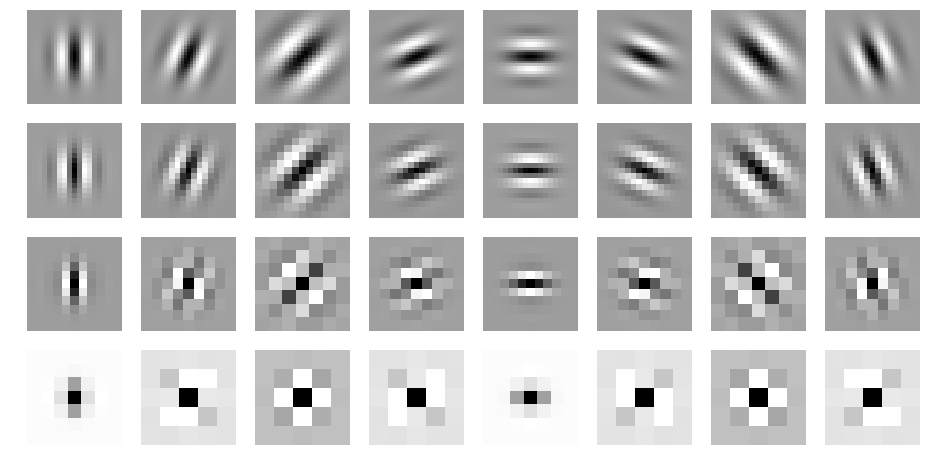

In [6]:
J=4 #number of scales
L=8 # number of angles per scale
filters = create_gabor_filterbank(J=4,L=8)
print(np.shape(filters))
print(np.shape(filters[0][0]))
#and the visualization: 
plt.figure(figsize=(16,8))
for j,scale in enumerate(filters):
    for l,kernel in enumerate(scale):
        #filters[j][l]=skimage.transform.resize(kernel,28,28)
        plt.subplot(J,L,j*L+l+1)
        #print(np.shape(filters[j][l]))
        plt.imshow(np.real(kernel),interpolation='nearest',cmap=plt.get_cmap("binary")) 
        plt.axis('off')
        #plt.viridis()
       
plt.show()

# The Scattering Transform
<div align="center">
 <img src="https://raw.githubusercontent.com/giulioisac/DNN-Study/master/ScatteringTransform.png" >
</div>

In [80]:
def compute_scattering(images, filters):
    #note that the filters have different sizes, thus easier to apply the conv
    # in the spatial domain

    print('Computing the scattering coefs. on ',len(images), ' images , this may take some time')
    feats1 = np.zeros((len(images), len(filters), len(filters[0]),2), dtype=np.float32)
    feats2 = np.zeros((len(images),len(filters)*len(filters[0]), len(filters), len(filters[0]),2), dtype=np.float32)
    filteredImages = []
    #Compute first order coefficients
    for i,image in enumerate(images):
        image_features=feats1[i] #pointer
        filteredPatch= []
        filteredImages.append(filteredPatch)
        for scale,scale_output in zip(filters,image_features):
            for kernel,kernel_l_output in zip(scale,scale_output):
                
                # |x * psi| * phi
                filtered = np.real(np.abs(ndi.convolve(image, kernel, mode='wrap')))
                filteredPatch.append(filtered)
                kernel_l_output[:] = filtered.mean(), (filtered ** 2).mean()
    print("first order coefficients computed")
    #compute second order coefficients
    for i,image in enumerate(images):
        if not(i%10):print(i)
        image_filtered=filteredImages[i]
        for j,filt in enumerate(image_filtered):
            image_features=feats2[i][j] #pointer
            for scale,scale_output in zip(filters,image_features):
                for kernel,kernel_l_output in zip(scale,scale_output):
                    # |x * psi| * phi
                    #downscaling
                    #filt1=skimage.transform.rescale(filt,0.5)
                    filtered = np.real(np.abs(ndi.convolve(filt, kernel, mode='wrap')))
                    kernel_l_output[:] = filtered.mean(), (filtered ** 2).mean()
    
    return feats1, feats2

## Computatin of Scattering Features for first and second layer of the transform (m=1,2)

In [81]:
#get a subset:
n_images=100
subMNIST=MNIST_im[:n_images]
scat_features1,scat_features2  = compute_scattering(subMNIST,filters)

Computing the scattering coefs. on  100  images , this may take some time


/home/matteo/.conda/envs/giuliobello/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


first order coefficients computed
0
10
20
30
40
50
60
70
80
90


/home/matteo/.conda/envs/giuliobello/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


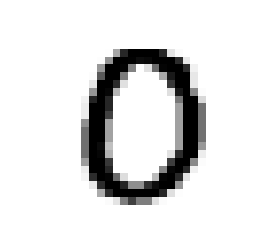

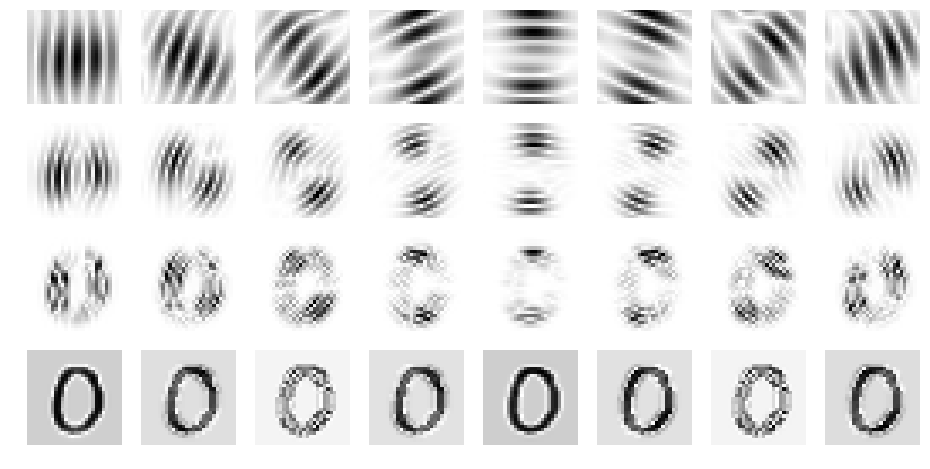

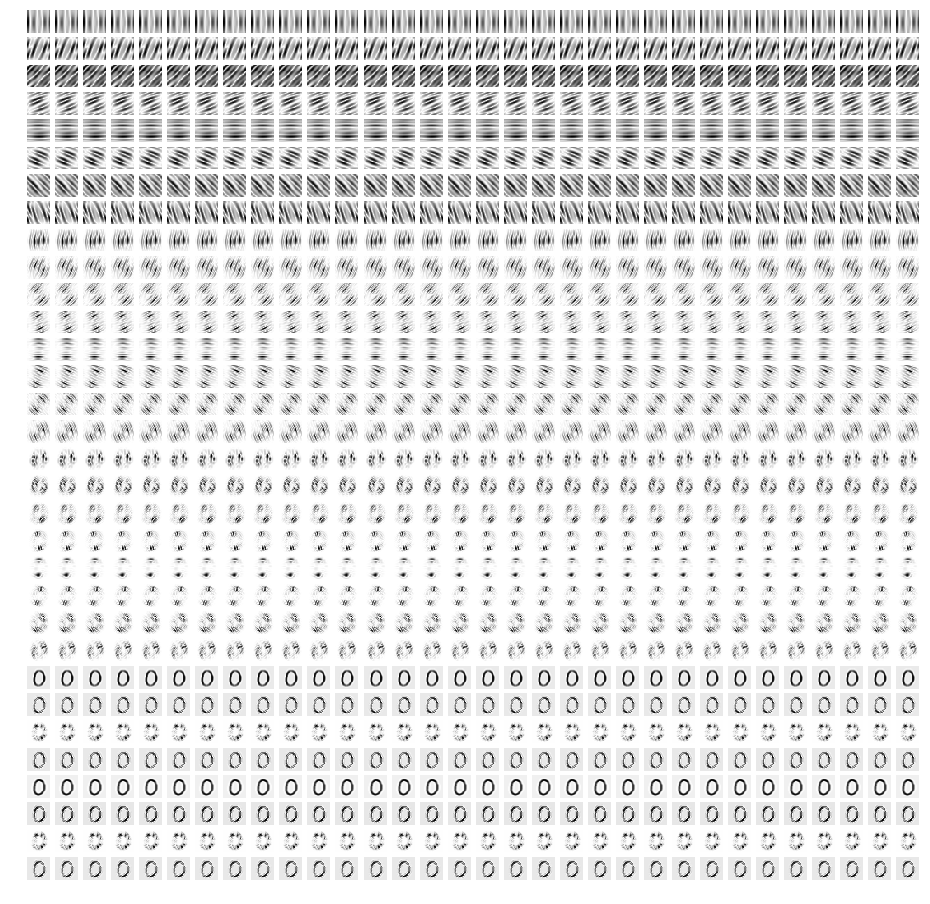

In [82]:
image=subMNIST[10]
plt.figure()
plt.axis('off')
plt.imshow(image,interpolation='nearest',cmap=plt.get_cmap("binary")) 

plt.figure(figsize=(16,8))
for j,scale in enumerate(filters):
    for l,kernel in enumerate(scale):
        filtered = np.real(np.abs(ndi.convolve(image, kernel, mode='wrap')))
        plt.subplot(4,8,j*8+l+1)
        plt.imshow(filtered,interpolation='nearest',cmap=plt.get_cmap("binary")) 
        plt.axis('off')
plt.figure(figsize=(16,16))
iterator=0
for j,scale in enumerate(filters):
    for l,kernel in enumerate(scale):
        filtered = np.real(np.abs(ndi.convolve(image, kernel, mode='wrap')))
        for j2,scale2 in enumerate(filters):
            for l2,kernel2 in enumerate(scale2):
                iterator=iterator+1
                filtered2 = np.real(np.abs(ndi.convolve(filtered, kernel, mode='wrap')))
                plt.subplot(32,32,iterator)
                plt.imshow(filtered2,interpolation='nearest',cmap=plt.get_cmap("binary")) 
                plt.axis('off')

### looks like something it is not working, the second order coefficients have no variability
maybe aliasing ---> problem

# Application of Linear Classifier in the transformed space

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import cross_val_score, KFold, ShuffleSplit

def from_features_to_classif_scores(scat_features_b,broadtz_labels):
    #stack them for learning
    scat_features_b = scat_features_b.reshape((len(scat_features_b),-1))
    # apply pipeline
    n = len(scat_features_b)
    pipeline = make_pipeline(Normalizer(),StandardScaler(),svm.SVC(kernel="linear"))
    cv = ShuffleSplit(n,n_iter=3,test_size=1, train_size=1)
    
    scat_scores_b = cross_val_score(pipeline,scat_features_b,broadtz_labels,cv=5,n_jobs=5)
    print('score:',scat_scores_b.mean())

In [84]:
#relabel mnist
labels= mnist.train.labels[:n_images]
MNISTlabels=np.zeros(n_images)
for i,label in enumerate(labels):
    for j in np.arange(10):
        if(labels[i][j]==1):MNISTlabels[i]=j

In [85]:
print('Scat initial BD, input for every image is:',np.shape(scat_features1.reshape((len(scat_features1),-1)))[1])
from_features_to_classif_scores(scat_features1,MNISTlabels)
print('Scat two layers BD, input for every image is:',np.shape(scat_features2.reshape((len(scat_features2),-1)))[1])
#from_features_to_classif_scores(scat_features2,all_labels)
from_features_to_classif_scores(scat_features2,MNISTlabels)
print('Patches initial BD, input for every image is:',np.shape(np.array(subMNIST).reshape((len(np.array(subMNIST)),-1)))[1])
from_features_to_classif_scores(np.array(subMNIST),MNISTlabels)

Scat initial BD, input for every image is: 64
score: 0.652032796924
Scat two layers BD, input for every image is: 2048
score: 0.729668061557
Patches initial BD, input for every image is: 784
score: 0.735528867417
